## A model build using TweetBERT to classify tweet as causal or non-causal 

The causal sentence prediction model will be trained in several steps using an active learning approach, where in each step the training dataset will be augmented.
In each step the causal sentence classifier is trained and applied on a subsample of unlabeled tweets to identify tweets with causal elements. Those tweets are then manually labeled for the two tasks: causal sentence prediction and cause-effect identification (NER). The newly labeled data will be added to the training dataset and the causal sentence classifier will be retrained with the augmented dataset to increase performance

In [15]:
import pandas as pd
import numpy as np
import spacy 
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import random
import os
import torch.nn.functional as F
import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, SubsetRandomSampler
import transformers
from tqdm import tqdm, trange
import io
from utils import normalizeTweet, split_into_sentences, EarlyStopping
import matplotlib.pyplot as plt


########################### DATA FILE ###################################
dataPath = "/home/adrian/workspace/causality/Causal-associations-diabetes-twitter/data/Causality_tweets_data.xlsx"


########################### MODEL PARAMETERS ############################
lr = 1e-3    
adam_eps = 1e-8
epochs = 3
num_warmup_steps = 0
early_patience = 3 # how long to wait after last time validation loss improved

train_batch_size = 64
val_batch_size = 32
test_batch_size = 32
test_to_train_ratio = 0.1 # 10% test and 90% train
val_to_train_ratio = 0.2

saveModelName = "finetuned-{}-epochs-lr_{}.pth".format(epochs, lr)

In [37]:
##### DATA TO LOAD ######

data = pd.read_excel(dataPath, sheet_name="round0")
data = data[data["Causal association"].notnull()] # some tweets at the end are not labeled yet
data = data[["full_text", "Intent", "Cause", "Effect", "Causal association"]]
print("Data (tweets!):")
print(data["Causal association"].value_counts())
print()

data.head()

Data (tweets!):
0.0    3710
1.0    1290
Name: Causal association, dtype: int64



,full_text,Intent,Cause,Effect,Causal association
0,"tonight , I learned my older girl will back he...",NaN,NaN,NaN,0.0
1,USER USER I knew diabetes and fibromyalgia wer...,joke,NaN,NaN,0.0
2,⬇ ️ ⬇ ️ ⬇ ️ THIS ⬇ ️ ⬇ ️ ⬇ ️ My wife has type ...,mS,NaN,NaN,0.0
3,USER Cheers ! Have one for this diabetic too !,mS,NaN,NaN,0.0
4,USER Additionally the medicines are being char...,NaN,medicines are being charged at MRP,costing much higher,1.0


### Preprocessing

In [7]:
def get_start_end_index_of_sentence_in_tweet(tweet, sentence):
    """ 
    The sentence tokens are included in the tweet tokens.
    Return the start end end indices of the sentence tokens in the tweet tokens

    """

    sentence_start_word = sentence[0]
    start_indices = [i for i, x in enumerate(tweet) if x == sentence_start_word] # find all indices of the start word of the sentence 
    try:
        for start_index in start_indices:
            isTrueStartIndex = all([tweet[start_index+i] == sentence[i] for i in range(len(sentence))])
            #print("start_index:", start_index, "isTrueStartIndex:", isTrueStartIndex)
            if isTrueStartIndex:
                return start_index, start_index + len(sentence) 
    except:
        print("ERROR: StartIndex should have been found for sentence:")
        print("tweet:")
        print(tweet)
        print("sentence:")
        print(sentence)
    return -1, -2 # should not be returned


def split_tweets_to_sentences(data):
    """ 
        Splits tweets into sentences and associates the appropriate intent, causes, effects and causal association
        to each sentence.
        
        Parameters:
        - min_words_in_sentences: Minimal number of words in a sentence such that the sentence is kept. 
                                  Assumption: A sentence with too few words does not have enough information
                              
                              
                              
        Ex.:
        full_text                              | Intent | Cause | Effect | Causal association | ...
        --------------------------------------------------------------------------------------------
        what? type 1 causes insulin dependence | q;msS  | type 1|insulin dependence | 1       | ...  
        
        New dataframe returned: 
        full_text                              | Intent | Cause | Effect | Causal association | ...
        --------------------------------------------------------------------------------------------
        what?                                  |   q    |       |        |       0            | ...
        type 1 causes insulin dependence       |        | type 1| insulin dependence | 1       | ...  
    """

    newDF = pd.DataFrame(columns=["sentence", "Intent", "Cause", "Effect", "Causal association", "tokenized"])
    
    for i,row in data.iterrows():
        causes = row["Cause"]
        effects = row["Effect"]
        sentences = split_into_sentences(normalizeTweet(row["full_text"]))
        
        # single sentence in tweet
        if len(sentences) == 1:
            singleSentenceIntent = ""
            if isinstance(row["Intent"], str):
                if len(row["Intent"].split(";")) > 1:
                    singleSentenceIntent = row["Intent"].strip().replace(";msS", "").replace("msS;", "").replace(";mS", "").replace("mS;", "")
                else:
                    if row["Intent"] == "mS" or row["Intent"] == "msS":
                        singleSentenceIntent = ""
                    else:
                        singleSentenceIntent = row["Intent"].strip()
                    
            newDF=newDF.append(pd.Series({"sentence": sentences[0] # only one sentence
                         , "Intent": singleSentenceIntent
                         , "Cause" : row["Cause"]
                         , "Effect": row["Effect"]
                         , "Causal association" : row["Causal association"]
                         , "tokenized": row["tokenized"]}), ignore_index=True)
        
        # tweet has several sentences
        else: 
            intents = str(row["Intent"]).strip().split(";")
            for sentence in sentences:
                sent_tokenized = sentence.split(" ")
                causeInSentence = np.nan if not isinstance(causes, str) or not any([cause in sentence for cause in causes.split(";")]) else ";".join([cause for cause in causes.split(";") if cause in sentence])
                effectInSentence = np.nan if not isinstance(effects, str) or not any([effect in sentence for effect in effects.split(";")]) else ";".join([effect for effect in effects.split(";") if effect in sentence])
                causalAssociationInSentence = 1 if isinstance(causeInSentence, str) and isinstance(effectInSentence, str) else 0
                startIndex, endIndex = get_start_end_index_of_sentence_in_tweet(row["tokenized"], sent_tokenized)
                sentence_tokenized = row["tokenized"][startIndex:endIndex]
                
                if "q" in intents and sentence[-1] == "?": # if current sentence is question
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": "q", "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized}), ignore_index=True)                    
                elif "joke" in intents: # all sentences with "joke" in tweet keep the intent "joke"
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": "joke", "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized}), ignore_index=True)   
                elif "neg" in intents: # all sentences with "neg" in tweet keep intent "neg"
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": "neg", "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized}), ignore_index=True)               
                elif isinstance(causeInSentence, str) and isinstance(effectInSentence, str): # cause effect sentence
                    causalIntent = ""
                    if len(causeInSentence.split(";")) > 1:
                        causalIntent = "mC"
                        if len(effectInSentence.split(";")) > 1:
                            causalIntent = "mC;mE"
                    elif len(effectInSentence.split(";")) > 1:
                        causalIntent = "mE"
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": causalIntent, "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized}), ignore_index=True)                                  
                else:
                    nonCausalIntent = ""
                    if isinstance(causeInSentence, str): # only cause is given
                        if len(causeInSentence.split(";")) > 1:
                            nonCausalIntent = "mC"
                    elif isinstance(effectInSentence, str): # only effect is given
                        if len(effectInSentence.split(";")) > 1:
                            nonCausalIntent = "mE"
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": nonCausalIntent, "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized}), ignore_index=True)

    return newDF

In [8]:
### Split tweets into sentences (train classifier on sentence level) ####

print("N tweets:", data.shape[0])

data["tokenized"] = data["full_text"].map(lambda tweet: normalizeTweet(tweet).split(" "))
dataSentences = split_tweets_to_sentences(data)
print("N sentences:", dataSentences.shape[0])
dataSentences.head()

N tweets: 5000
N sentences: 11756


,sentence,Intent,Cause,Effect,Causal association,tokenized
0,"tonight , I learned my older girl will back he...",,NaN,NaN,0,"[tonight, ,, I, learned, my, older, girl, will..."
1,Fiercely .,,NaN,NaN,0,"[Fiercely, .]"
2,#impressive #bigsister #type1 #type1times2,,NaN,NaN,0,"[#impressive, #bigsister, #type1, #type1times2]"
3,USER USER I knew diabetes and fibromyalgia wer...,joke,NaN,NaN,0,"[USER, USER, I, knew, diabetes, and, fibromyal..."
4,:face_with_rolling_eyes:,joke,NaN,NaN,0,[:face_with_rolling_eyes:]


In [9]:
########## Remove sentences with joke, question, negation and keep only sentences with more than 3 tokens #####

print("N sentences before filtering: ", dataSentences.shape[0])
dataSentFiltered = dataSentences[~dataSentences["Intent"].str.contains("neg|joke|q")] 
dataSentFiltered = dataSentFiltered[dataSentFiltered["tokenized"].map(len) > 3] 
print("N sentences after filtering: ", dataSentFiltered.shape[0])
print("Distribution:")
print(dataSentFiltered["Causal association"].value_counts())
dataSentFiltered.head()

N sentences before filtering:  11756
N sentences after filtering:  8368
Distribution:
0.0    7320
1.0    1048
Name: Causal association, dtype: int64


,sentence,Intent,Cause,Effect,Causal association,tokenized
0,"tonight , I learned my older girl will back he...",,NaN,NaN,0,"[tonight, ,, I, learned, my, older, girl, will..."
2,#impressive #bigsister #type1 #type1times2,,NaN,NaN,0,"[#impressive, #bigsister, #type1, #type1times2]"
5,:down_arrow: :down_arrow: :down_arrow: THIS :d...,,NaN,NaN,0,"[:down_arrow:, :down_arrow:, :down_arrow:, THI..."
6,I 'm a trans woman .,,NaN,NaN,0,"[I, 'm, a, trans, woman, .]"
7,"Both of us could use a world where "" brave and...",,NaN,NaN,0,"[Both, of, us, could, use, a, world, where, "",..."


### Training

In [10]:
####################### Stratified splits ####################


## ONLY FOR TESTING ---------------
#dataSentFiltered = dataSentFiltered[0:500] # for testing

text = dataSentFiltered["sentence"].map(normalizeTweet).values.tolist()
labels = dataSentFiltered["Causal association"].values.tolist()
# first split the data into training and testing label in the ratio of 90:10
train_texts, test_texts, train_labels, test_labels = train_test_split(text, labels, test_size=test_to_train_ratio, stratify=labels, random_state=9)

# Optional:split the new training data (80% of actual data) to get train and validation set
# But we choose in each epoch another part of the training data to be the validation set
#train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2, stratify=train_labels, random_state=9)



data_count_info = pd.Series(labels).value_counts(normalize=True)
train_count_info = pd.Series(train_labels).value_counts(normalize=True)
#val_count_info = pd.Series(val_labels).value_counts(normalize=True)
test_count_info = pd.Series(test_labels).value_counts(normalize=True)

# for class-imbalanced dataset, the class weight for a ith class
# to be specified for balancing in the loss function is given by:
# weight[i] = num_samples / (num_classes * num_samples[i])
# since train_count_info obtained above has fraction of samples
# for ith class, hence the corresponding weight calculation is:
class_weight = (1/train_count_info)/len(train_count_info)

print("All: Count = {}, % of 0 = {}, % of 1 = {}".format(
    len(labels), *data_count_info.round(4).to_list()))
print("Train: Count = {}, % of 0 = {}, % of 1 = {}".format(
    len(train_labels), *train_count_info.round(4).to_list()))
#print("Val: Count = {}, % of 0 = {}, % of 1 = {}".format(
#    len(val_labels), *val_count_info.round(4).to_list()))
print("Test: Count = {}, % of 0 = {}, % of 1 = {}".format(
    len(test_labels), *test_count_info.round(4).to_list()))
print("Balancing class wts: for 0 = {}, for 1 = {}".format(
    *class_weight.round(4).to_list()))

All: Count = 500, % of 0 = 0.852, % of 1 = 0.148
Train: Count = 450, % of 0 = 0.8511, % of 1 = 0.1489
Test: Count = 50, % of 0 = 0.86, % of 1 = 0.14
Balancing class wts: for 0 = 0.5875, for 1 = 3.3582


In [34]:
class TweetDataSet(torch.utils.data.Dataset):
    def __init__(self, text, labels, tokenizer):
        self.text = text
        self.labels = labels
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        inputs = self.tokenizer(self.text, padding=True, truncation=True, return_token_type_ids=True)
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]
        return {
                "input_ids" : torch.tensor(ids[idx], dtype=torch.long)
              , "attention_mask" : torch.tensor(mask[idx], dtype=torch.long)
              , "token_type_ids" : torch.tensor(token_type_ids[idx], dtype=torch.long)
              , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
        }      

    def __len__(self):
        return len(self.labels)

    
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")

train_dataset = TweetDataSet(train_texts, train_labels, tokenizer)
#val_dataset = TweetDataSet(val_texts, val_labels, tokenizer)
test_dataset = TweetDataSet(test_texts, test_labels, tokenizer)
print(len(train_dataset))
#print(len(val_dataset))
print(len(test_dataset))

# During training: In each epoch one part of the training data will be used as validation set
#train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
#validation_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


450
50


### Model defintion

In [12]:
## we are measuring weighted metrics - as our dataset is imbalanced 
# Calculate metrics for each label, and find their average weighted by support
# (the number of true instances for each label). 
# This alters ‘macro’ to account for label imbalance; 
# it can result in an F-score that is not between precision and recall.


from sklearn.metrics import accuracy_score, precision_recall_fscore_support, matthews_corrcoef

def compute_metrics(pred, labels):
    precision, recall, f1, _ = precision_recall_fscore_support(labels, pred, average='weighted')
    acc = accuracy_score(labels, pred)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }



class CausalityBERT(torch.nn.Module):
    """ Model Bert"""
    def __init__(self):
        super(CausalityBERT, self).__init__()
        self.num_labels = 2
        self.bert = transformers.BertModel.from_pretrained("vinai/bertweet-base")
        self.dropout = torch.nn.Dropout(0.3)
        self.linear1 = torch.nn.Linear(768, 256)
        self.linear2 = torch.nn.Linear(256, self.num_labels)
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, output_1 = self.bert(input_ids, attention_mask = attention_mask, token_type_ids=token_type_ids, return_dict=False) # if output 1 is our cls token        
        output_2 = self.dropout(output_1)
        output_3 = self.linear1(output_2)  
        output_4 = self.dropout(output_3)
        output_5 = self.linear2(output_4)
        return output_5



    


In [26]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = CausalityBERT()
model.to(device)

# fine-tune only the task-specific parameters
for param in model.bert.parameters():
    param.requires_grad = False

num_training_steps = np.ceil(len(train_dataset)/train_batch_size)*epochs
optim = AdamW(model.parameters(), lr=lr, eps=adam_eps)
scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps) # scheduler with a linearly decreasing learning rate from the initial lr set in the optimizer to 0; after a warmup period durnig which it increases linearly from 0 to the initial lr set in the optimizer

## penalising more for class with less number of exaplmes 
loss_fn = CrossEntropyLoss(torch.tensor(class_weight.to_list()).to(device))

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing BertModel: ['lm_head.layer_norm.weight', 'roberta.encoder.layer.8.attention.self.value.weight', 'roberta.encoder.layer.7.attention.self.query.weight', 'roberta.encoder.layer.9.attention.self.key.weight', 'roberta.encoder.layer.8.attention.self.key.bias', 'roberta.encoder.layer.11.output.dense.bias', 'roberta.encoder.layer.11.attention.self.key.weight', 'roberta.encoder.layer.6.attention.output.LayerNorm.bias', 'roberta.encoder.layer.3.attention.self.key.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.value.weight', 'roberta.encoder.layer.8.attention.self.key.weight', 'roberta.encoder.layer.6.attention.self.query.weight', 'roberta.encoder.layer.1.output.dense.weight', 'roberta.encoder.la

Some weights of BertModel were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.2.attention.self.key.weight', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.4.output.dense.bias', 'encoder.layer.9.output.LayerNorm.bias', 'encoder.layer.3.attention.output.LayerNorm.weight', 'encoder.layer.4.intermediate.dense.weight', 'encoder.layer.10.attention.self.query.bias', 'encoder.layer.5.output.LayerNorm.bias', 'encoder.layer.2.attention.output.dense.bias', 'encoder.layer.8.output.LayerNorm.weight', 'encoder.layer.5.intermediate.dense.weight', 'encoder.layer.11.intermediate.dense.weight', 'encoder.layer.11.attention.self.key.weight', 'encoder.layer.6.attention.self.value.weight', 'encoder.layer.4.intermediate.dense.bias', 'encoder.layer.1.attention.output.dense.bias', 'encoder.layer.10.intermediate.dense

In [27]:
############ TRAINING #############

# initialise the early_stopping object
early_stopping = EarlyStopping(patience=early_patience, path=saveModelName, verbose=True)

train_size = len(train_texts)
train_indices = list(range(train_size))

train_avg_loss = [] # avg training loss per epoch
val_avg_loss = [] # avg validation loss per epoch
train_avg_acc = [] # avg training accuracy per epoch
val_avg_acc = [] # avg val accuracy per epoch
n_trained_epochs = 0


for epoch in trange(1, epochs+1, desc='Epoch'):
    print("<" + "="*22 + F" Epoch {epoch} "+ "="*22 + ">")
    
    
    ###### Trick: Take in each epoch different indices from training data to be used as validation  ########
    np.random.shuffle(train_indices)
    val_split_index = int(np.floor(val_to_train_ratio * train_size))
    # Validation goes from index 0..val_split_index; training set goes from index val_split_index..end 
    train_sampler = SubsetRandomSampler(train_indices[val_split_index:])
    val_sampler = SubsetRandomSampler(train_indices[:val_split_index])
    train_loader = DataLoader(dataset=train_dataset, shuffle=False, batch_size=train_batch_size,sampler=train_sampler)
    validation_loader = DataLoader(dataset=train_dataset, shuffle=False, batch_size=val_batch_size,sampler=val_sampler)
    
    
    
    ########### training eval metrics #############################
    train_accuracy = []
    train_loss = []
    train_acc = []
    train_prec = []
    train_rec = []
    train_f1 = []
    
    ###################################################
    
    for batch in tqdm(train_loader):
        optim.zero_grad() # gradients get accumulated by default -> clear previous accumulated gradients
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        labels = batch['labels'].to(device)
        ###########################################################################
        model.train()
        logits = model(**{"input_ids":input_ids, "attention_mask":attention_mask, "token_type_ids":token_type_ids}) # forward pass
        #############################################################################
        loss = loss_fn(logits, labels)
        print("loss:", loss)
        loss.backward() # backward pass
        optim.step()    # update parameters and take a step up using the computed gradient
        scheduler.step()# update learning rate scheduler
        train_loss.append(loss.item())
        
    
        ############# Training Accuracy Measure ###################################

        # move logits and labels to CPU
        logits = logits.detach().to('cpu').numpy()
        label_ids = labels.to('cpu').numpy()

        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()

        metrics = compute_metrics(pred_flat, labels_flat)        
        
        train_acc.append(metrics["accuracy"])
        train_prec.append(metrics["precision"])
        train_rec.append(metrics["recall"])
        train_f1.append(metrics["f1"])
        
    train_avg_loss.append(np.mean(train_loss))
    train_avg_acc.append(np.mean(train_acc))
    print(F'\n\tTrain loss: {np.mean(train_loss)}')
    print(F'\n\ttrain acc: {np.mean(train_acc)}')
    print(F'\n\ttraining prec: {np.mean(train_prec)}')
    print(F'\n\ttraining rec: {np.mean(train_rec)}')
    print(F'\n\ttraining f1: {np.mean(train_f1)}')
    
    n_trained_epochs += 1
    
    ###################################################################################

    
    ## ---- Validation ------
    val_accuracy = []
    val_loss = []
    val_acc = []
    val_prec = []
    val_rec = []
    val_f1 = []
    
    
    # Evaluate data for one epoch
    for batch in tqdm(validation_loader):
        batch = tuple(batch[t].to(device) for t in batch)      # batch to GPU
        b_input_ids, b_input_mask, b_token_type_ids, b_labels = batch     # unpack inputs from dataloader
        
        with torch.no_grad(): # tell model not to compute or store gradients -> saves memory + speeds up validation
            ##################################################################################
            model.eval()
            logits = model(**{"input_ids":b_input_ids, "attention_mask":b_input_mask, "token_type_ids":b_token_type_ids}) # forward pass, calculates logit predictions 

                        
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())
        
        # move logits and labels to CPU
        logits = logits.detach().to('cpu').numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        
        metrics = compute_metrics(pred_flat, labels_flat)
        val_acc.append(metrics["accuracy"])
        val_prec.append(metrics["precision"])
        val_rec.append(metrics["recall"])
        val_f1.append(metrics["f1"])

    val_avg_loss.append(np.mean(val_loss))
    val_avg_acc.append(np.mean(val_acc))
    print(F'\n\tValidation loss: {np.mean(val_loss)}')
    print(F'\n\tValidation acc: {np.mean(val_acc)}')
    print(F'\n\tValidation prec: {np.mean(val_prec)}')
    print(F'\n\tValidation rec: {np.mean(val_rec)}')
    print(F'\n\tValidation f1: {np.mean(val_f1)}')

    # early_stopping needs the validation loss to check if it has decreased,
    # and if it has, it will make a checkpoint of the current model
    early_stopping(np.average(val_loss), model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break

  0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-fd35bfb1853b>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)


<====================== Epoch 1 ======================>
{}{}{}{}{}{}{}{}{}{}{}{}{}{}{}{}{}
[331, 296, 142, 144, 190, 92, 373, 276, 70, 90, 359, 10, 143, 269, 49, 203, 176, 230, 89, 417, 411, 105, 383, 306, 391, 321, 37, 68, 397, 47, 344, 125, 377, 385, 135, 15, 290, 79, 360, 41, 130, 174, 376, 51, 301, 60, 138, 140, 45, 336, 83, 19, 14, 31, 82, 284, 57, 286, 328, 351, 4, 160, 356, 310, 339, 433, 226, 87, 39, 32, 9, 146, 94, 136, 38, 175, 204, 332, 414, 114, 295, 314, 307, 149, 361, 211, 173, 153, 5, 20]



 17%|█▋        | 1/6 [00:08<00:44,  8.94s/it]

loss: tensor(0.7333, grad_fn=<NllLossBackward>)


<ipython-input-11-fd35bfb1853b>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 2/6 [00:17<00:35,  8.76s/it]

loss: tensor(0.9998, grad_fn=<NllLossBackward>)


<ipython-input-11-fd35bfb1853b>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|█████     | 3/6 [00:26<00:27,  9.04s/it]

loss: tensor(0.7118, grad_fn=<NllLossBackward>)


<ipython-input-11-fd35bfb1853b>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 4/6 [00:35<00:17,  8.95s/it]

loss: tensor(0.6729, grad_fn=<NllLossBackward>)


<ipython-input-11-fd35bfb1853b>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 83%|████████▎ | 5/6 [00:44<00:09,  9.00s/it]

loss: tensor(0.9102, grad_fn=<NllLossBackward>)


<ipython-input-11-fd35bfb1853b>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 6/6 [00:50<00:00,  8.45s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

loss: tensor(0.6902, grad_fn=<NllLossBackward>)

	Train loss: 0.7863632440567017

	train acc: 0.4005208333333334

	training prec: 0.5039967764433103

	training rec: 0.4005208333333334

	training f1: 0.33839122195300964


<ipython-input-11-fd35bfb1853b>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 1/3 [00:04<00:08,  4.08s/it]<ipython-input-11-fd35bfb1853b>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklear


	Validation loss: 0.6613787015279134

	Validation acc: 0.1658653846153846

	Validation prec: 0.02774631718441815

	Validation rec: 0.1658653846153846

	Validation f1: 0.04748863235705342
Validation loss decreased (inf --> 0.661379).  Saving model ...


  0%|          | 0/6 [00:00<?, ?it/s]<ipython-input-11-fd35bfb1853b>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)


<====================== Epoch 2 ======================>
{}{}{}{}{}{}{}{}{}{}{}{}{}{}{}{}{}
[185, 210, 259, 288, 342, 208, 293, 180, 402, 392, 378, 24, 245, 407, 275, 292, 334, 421, 271, 150, 352, 106, 301, 111, 281, 308, 31, 182, 87, 202, 341, 346, 319, 358, 214, 284, 5, 58, 148, 119, 8, 187, 398, 309, 146, 449, 143, 443, 362, 98, 427, 164, 14, 400, 389, 131, 234, 96, 287, 282, 73, 171, 114, 440, 141, 395, 81, 68, 413, 274, 104, 12, 173, 297, 30, 192, 419, 228, 43, 162, 163, 391, 100, 340, 135, 240, 432, 377, 248, 125]



 17%|█▋        | 1/6 [00:08<00:43,  8.72s/it]

loss: tensor(0.6493, grad_fn=<NllLossBackward>)


<ipython-input-11-fd35bfb1853b>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 2/6 [00:17<00:35,  9.00s/it]

loss: tensor(0.6737, grad_fn=<NllLossBackward>)


<ipython-input-11-fd35bfb1853b>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|█████     | 3/6 [00:26<00:26,  8.82s/it]

loss: tensor(0.7390, grad_fn=<NllLossBackward>)


<ipython-input-11-fd35bfb1853b>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 4/6 [00:36<00:18,  9.37s/it]

loss: tensor(0.5806, grad_fn=<NllLossBackward>)


<ipython-input-11-fd35bfb1853b>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 5/6 [00:45<00:09,  9.22s/it]

loss: tensor(0.6926, grad_fn=<NllLossBackward>)


<ipython-input-11-fd35bfb1853b>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

100%|██████████| 6/6 [00:50<00:00,  8.49s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

loss: tensor(0.6541, grad_fn=<NllLossBackward>)

	Train loss: 0.6648796101411184

	train acc: 0.6843750000000001

	training prec: 0.7889891306488469

	training rec: 0.6843750000000001

	training f1: 0.6844228952644545


<ipython-input-11-fd35bfb1853b>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 1/3 [00:04<00:08,  4.08s/it]<ipython-input-11-fd35bfb1853b>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/sklear


	Validation loss: 0.6942933201789856

	Validation acc: 0.8317307692307692

	Validation prec: 0.6920649963017752

	Validation rec: 0.8317307692307692

	Validation f1: 0.7554197065105828
EarlyStopping counter: 1 out of 3
<====================== Epoch 3 ======================>
{}{}{}{}{}{}{}{}{}{}{}{}{}{}{}{}{}
[191, 278, 439, 416, 421, 194, 198, 84, 113, 438, 265, 284, 122, 263, 396, 77, 252, 332, 336, 227, 64, 429, 173, 415, 388, 375, 139, 290, 196, 365, 211, 33, 98, 202, 161, 447, 247, 371, 132, 51, 296, 372, 9, 75, 308, 311, 183, 235, 412, 411, 96, 258, 78, 127, 180, 190, 189, 435, 369, 231, 120, 366, 237, 17, 307, 295, 25, 221, 222, 449, 71, 370, 144, 376, 131, 342, 385, 243, 337, 286, 118, 324, 343, 69, 338, 16, 59, 381, 432, 309]


<ipython-input-11-fd35bfb1853b>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 17%|█▋        | 1/6 [00:09<00:46,  9.33s/it]

loss: tensor(0.6273, grad_fn=<NllLossBackward>)


<ipython-input-11-fd35bfb1853b>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 2/6 [00:18<00:37,  9.32s/it]

loss: tensor(0.7226, grad_fn=<NllLossBackward>)


<ipython-input-11-fd35bfb1853b>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 50%|█████     | 3/6 [00:27<00:27,  9.29s/it]

loss: tensor(0.6697, grad_fn=<NllLossBackward>)


<ipython-input-11-fd35bfb1853b>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 4/6 [00:38<00:19,  9.84s/it]

loss: tensor(0.6684, grad_fn=<NllLossBackward>)


<ipython-input-11-fd35bfb1853b>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 83%|████████▎ | 5/6 [00:47<00:09,  9.43s/it]

loss: tensor(0.6319, grad_fn=<NllLossBackward>)


<ipython-input-11-fd35bfb1853b>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

100%|██████████| 6/6 [00:53<00:00,  8.88s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

loss: tensor(0.6466, grad_fn=<NllLossBackward>)

	Train loss: 0.6610898673534393

	train acc: 0.7182291666666667

	training prec: 0.8086913246285846

	training rec: 0.7182291666666667

	training f1: 0.7414985415582943


<ipython-input-11-fd35bfb1853b>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 33%|███▎      | 1/3 [00:04<00:08,  4.08s/it]<ipython-input-11-fd35bfb1853b>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

 67%|██████▋   | 2/3 [00:08<00:04,  4.45s/it]<ipython-input-11-fd35bfb1853b>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)

100%|██████████| 3/3 [00:12<00:00,  4.05s/it]



	Validation loss: 0.6273249785105387

	Validation acc: 0.53125

	Validation prec: 0.8334754153010732

	Validation rec: 0.53125

	Validation f1: 0.5864355458782703
Validation loss decreased (0.661379 --> 0.627325).  Saving model ...


Epoch: 100%|██████████| 3/3 [03:12<00:00, 64.11s/it]


In [28]:
print(n_trained_epochs)
print(train_avg_loss)
print(val_avg_loss)

3
[0.7863632440567017, 0.6648796101411184, 0.6610898673534393]
[0.6613787015279134, 0.6942933201789856, 0.6273249785105387]


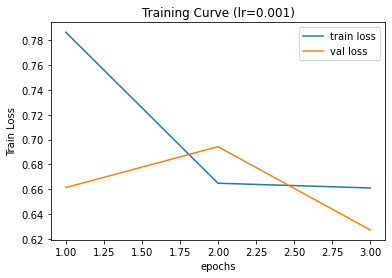

In [29]:
plt.plot(range(1, n_trained_epochs+1), train_avg_loss, label="train loss")
plt.plot(range(1, n_trained_epochs+1), val_avg_loss, label="val loss")
plt.title("Training Curve (lr={})".format(lr))
plt.xlabel("epochs")
plt.ylabel("Train Loss")
plt.legend(loc="best")
plt.show()

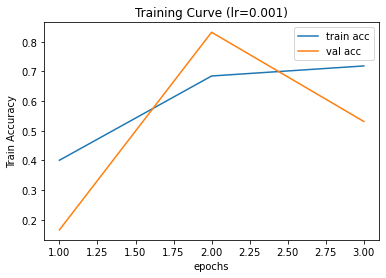

In [31]:
plt.plot(range(1, n_trained_epochs+1), train_avg_acc, label="train acc")
plt.plot(range(1, n_trained_epochs+1), val_avg_acc, label="val acc")
plt.title("Training Curve (lr={})".format(lr))
plt.xlabel("epochs")
plt.ylabel("Train Accuracy")
plt.legend(loc="best")
plt.show()

In [23]:
## saving the model 
##torch.save(model.state_dict(), "finetuned-35-epochs-1e3-lr-with-weighted-loss.pth") # early stopping saves model

In [21]:
# loading the locally saved model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CausalityBERT()
model.load_state_dict(torch.load("finetuned-35-epochs-1e3-lr-with-weighted-loss.pth"))
## Move the model to the GPU 
model.to(device)
model.eval() # gettign in the eval mode 



You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing BertModel: ['roberta.encoder.layer.6.attention.self.key.bias', 'roberta.encoder.layer.9.intermediate.dense.weight', 'roberta.encoder.layer.8.attention.self.value.bias', 'roberta.encoder.layer.5.attention.self.query.bias', 'roberta.encoder.layer.9.attention.output.dense.bias', 'roberta.encoder.layer.5.attention.self.value.weight', 'roberta.encoder.layer.7.attention.output.LayerNorm.weight', 'roberta.encoder.layer.6.attention.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.self.value.weight', 'roberta.encoder.layer.9.attention.self.key.bias', 'roberta.encoder.layer.6.intermediate.dense.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'lm_head.dense.bias', 'roberta.encoder.layer.4.intermediate.dense.weight', 'roberta.e

CausalityBERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True

## evaluation on the test dataset 



In [36]:
#loss_fn = CrossEntropyLoss()
test_loss = []
test_acc = []
test_prec = []
test_rec = []
test_f1 = []


for batch in tqdm(test_loader):
    batch = tuple(batch[t].to(device) for t in batch)      # batch to GPU
    b_input_ids, b_input_mask, b_token_type_ids, b_labels = batch     # unpack inputs from dataloader

    with torch.no_grad():
        model.eval()
        logits = model(**{"input_ids":b_input_ids, "attention_mask":b_input_mask, "token_type_ids":b_token_type_ids}) # forward pass, calculates logit predictions 
    
    # move logits and labels to CPU
    logits = logits.detach().to('cpu').numpy()
    label_ids = b_labels.to('cpu').numpy()

    pred_flat = np.argmax(logits, axis=1).flatten()
    labels_flat = label_ids.flatten()
    
    metrics = compute_metrics(pred_flat, labels_flat)
    test_acc.append(metrics["accuracy"])
    test_prec.append(metrics["precision"])
    test_rec.append(metrics["recall"])
    test_f1.append(metrics["f1"])

    
print(F'\n\ttest loss: {np.mean(test_loss)}')
print(F'\n\ttest acc: {np.mean(test_acc)}')
print(F'\n\ttest prec: {np.mean(test_prec)}')
print(F'\n\ttest rec: {np.mean(test_rec)}')
print(F'\n\ttest f1: {np.mean(test_f1)}')





  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-34-285408ed5860>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
 50%|█████     | 1/2 [00:02<00:02,  2.83s/it]<ipython-input-34-285408ed5860>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
100%|██████████| 2/2 [00:05<00:00,  2.72s/it]


	test loss: nan

	test acc: 0.5347222222222222

	test prec: 0.8143518518518519

	test rec: 0.5347222222222222

	test f1: 0.5866545893719807



/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/adrian/miniconda3/envs/pytorch/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Print predictions of last test set batch:

In [30]:
# take last batch of test set:

for i in range(len(batch)):
    tokens = tokenizer.convert_ids_to_tokens(b_input_ids[i])
    print("\nPadded Sentence:")
    print(tokens)
    print("prediction:", pred_flat[i])
    


Padded Sentence:
['<s>', '100', '%', 'life', '/', 'death', 'situation', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
prediction: 0

Padded Sentence:
['<s>', 'USER', 'I', "'m", 'diabetic', ',', 'but', 'I', 'would', 'buy', 'a', 'dozen', 'anyway', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',

In [78]:
# add seed => check
# add binary accuracy  => ???????
# add plot loss function accuracy => validation accu

# y - axis: loss function; validation accuracy
# x - axis: epochs


# epochs, learning rate => ok

# 90% training => 10% test  => ok
# how to use random batch of training set for validation

# clean notebook

# clean data sheet => check

# Check Pytorch: EarlyStopping add => check